# Which borough has the most noise complaints (or, more selecting data)

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# !pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", port="auto", reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:8082
SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/76a3a00ca90e485985f05c9ddcc7418d.sqlite



# Data owner: upload data

In [ ]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from syft import Worker, MessageStatus
from syft.service.project.project import Project
from syft.util.util import PANDAS_DATA

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [6]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [7]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

In [8]:
from syft.serde.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,825816,1992-07-03 18:24:55,2019-04-23 01:40:33,NYPD,Kenneth Prince,'Animal in a Park',Broken Fence,Pool,62435,"472 Jamie Green\nMelissafort, RI 33541",Katherine Sanchez,Michael Harbor,Johnson Stravenue,Elizabeth Passage,Julie Route,BLOCKFACE,Port Susanborough,WORLDS FAIR MARINA,DSNY Garage,Assigned,2008-09-15 07:53:19,2014-05-11 08:56:58,11 QUEENS,Unspecified,323240,920116,Gary Gray,STATEN ISLAND,Johnny Williams,B111,Region 1,01M361,7187568400,"9836 Joseph Glen Apt. 300\nPort Elizabeth, OR ...",JAMAICA,NY,68227,Y,NaN,Commuter Van,MANHATTAN,Other,Henry Hudson Pkwy/Rt 9A,Southbound,NaN,Grand Central Pkwy (Exit 1 E-W),Ave M Field,Staten Island Bound,Molinari,-76.768586,159.445697,"(-105.719650, 112.053614)"
1,170343,1982-07-16 23:36:23,2011-08-20 19:06:57,DOHMH,Patrick Hall,Illegal Parking,Broken Glass,Hospital,98413,"524 Lori Station Apt. 939\nChristopherfurt, ME...",Abigail Smith,Fitzgerald Knolls,Allen Circles,Johnson Villages,Jennifer Port,BLOCKFACE,Lisaview,METROPOLITAN MUSEUM,Precinct,Pending,2011-03-02 21:41:26,1973-10-05 19:01:04,01 BRONX,BROOKLYN,855461,956506,Gregory Smith,BRONX,Cheryl Simpson,B073,Region 5,28Q139,7186672165,"328 Proctor Squares\nPort Michael, VI 29322",CORONA,NY,91659,Y,NaN,Commuter Van,QUEENS,Other,Queens Midtown Tunnel,North/Bronx Bound,NaN,Harding Ave (Exit 9) - Throgs Neck Br,Ave M Field,Staten Island Bound,PREMIER,92.881048,-127.571770,"(-9.127721, -160.961191)"
2,504430,2017-07-13 12:39:54,2001-02-28 04:29:35,DOHMH,Shannon Hughes,'Animal in a Park',Broken Fence,Vehicle Lane,07414,"PSC 7552, Box 0365\nAPO AA 77847",Dawn Hartman,Simon Orchard,Antonio Cape,Kevin Ways,Santos Walks,NaN,Davidville,BRYANT PARK,DSNY Garage,Unassigned,1986-06-18 03:51:20,1993-11-26 20:14:59,11 MANHATTAN,BRONX,598460,979114,Mr. Christopher Hill,QUEENS,Donald Smith,B111,Region 8,10X046,7189673542,"179 Sanders Falls Suite 759\nLake Stevenland, ...",HOLLIS,Unspecified,58522,Y,NaN,Car Service,MANHATTAN,Intersection,NaN,South/New Jersey Bound,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Staten Island Bound,GAYLORD WHITE SENIOR CENTER,-119.630480,-3.946135,"(71.487651, 153.480617)"
3,596454,2018-10-21 13:14:50,1981-09-13 21:21:45,DPR,Jacob Lowe,Illegal Parking,Branch or Limb Has Fallen Down,NaN,69527,"440 Tanner Roads Suite 955\nEast Ashleyberg, C...",Jacob Lowe,Rodriguez Meadows,Johnson Stravenue,James Walks,Brady Key,BLOCKFACE,Port Richard,GRAND ARMY PLAZA,Precinct,Closed,1986-06-18 03:51:20,2001-08-11 09:34:40,09 QUEENS,Unspecified,224401,588525,Charlotte Hawkins,BROOKLYN,James Reeves,B100,Region 7,02M001,7184301800,"116 Petty Trace Suite 254\nWest Jenniferfurt, ...",COLLEGE POINT,NY,98413,Y,NaN,Ambulette / Paratransit,STATEN ISLAND,La Guardia Airport,Sheridan Expwy,NaN,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,Manhattan Bound,St. George Terminal (Staten Island),71.487651,-35.756310,"(84.881288, 93.177392)"
4,272448,1984-07-20 00:43:48,1997-02-25 04:57:29,DOHMH,Abigail Smith,Noise - Street/Sidewalk,Branches Damaged,Vacant Lot,23936,"46673 Allen Fall Apt. 532\nDanielfurt, DC 04659",Edward Morgan,Hannah Cliff,Daniel Glen,Dougherty Dale,Lisa Station,NaN,Williammouth,BARCLAYS CENTER,School,Em

In [15]:
dataset = sy.Dataset(name="bikes",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)


  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: Create result pointer

## Download mock and request pointer

### Get mock

In [26]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [27]:
ds = guest_domain_client.datasets[0]

In [28]:
asset = ds.assets["complaints"]

In [29]:
complaints_pointer = asset.mock

### Selecting only noise complaints


I'd like to know which borough has the most noise complaints. First, we'll take a look at the data to see what it looks like:

In [30]:
complaints_pointer[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,825816,1992-07-03 18:24:55,2019-04-23 01:40:33,NYPD,Kenneth Prince,'Animal in a Park',Broken Fence,Pool,62435,"472 Jamie Green\nMelissafort, RI 33541",Katherine Sanchez,Michael Harbor,Johnson Stravenue,Elizabeth Passage,Julie Route,BLOCKFACE,Port Susanborough,WORLDS FAIR MARINA,DSNY Garage,Assigned,2008-09-15 07:53:19,2014-05-11 08:56:58,11 QUEENS,Unspecified,323240,920116,Gary Gray,STATEN ISLAND,Johnny Williams,B111,Region 1,01M361,7187568400,"9836 Joseph Glen Apt. 300\nPort Elizabeth, OR ...",JAMAICA,NY,68227,Y,NaN,Commuter Van,MANHATTAN,Other,Henry Hudson Pkwy/Rt 9A,Southbound,None,Grand Central Pkwy (Exit 1 E-W),Ave M Field,Staten Island Bound,Molinari,-76.768586,159.445697,"[-105.719650, 112.053614]"
1,170343,1982-07-16 23:36:23,2011-08-20 19:06:57,DOHMH,Patrick Hall,Illegal Parking,Broken Glass,Hospital,98413,"524 Lori Station Apt. 939\nChristopherfurt, ME...",Abigail Smith,Fitzgerald Knolls,Allen Circles,Johnson Villages,Jennifer Port,BLOCKFACE,Lisaview,METROPOLITAN MUSEUM,Precinct,Pending,2011-03-02 21:41:26,1973-10-05 19:01:04,01 BRONX,BROOKLYN,855461,956506,Gregory Smith,BRONX,Cheryl Simpson,B073,Region 5,28Q139,7186672165,"328 Proctor Squares\nPort Michael, VI 29322",CORONA,NY,91659,Y,NaN,Commuter Van,QUEENS,Other,Queens Midtown Tunnel,North/Bronx Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,Ave M Field,Staten Island Bound,PREMIER,92.881048,-127.571770,"[-9.127721, -160.961191]"
2,504430,2017-07-13 12:39:54,2001-02-28 04:29:35,DOHMH,Shannon Hughes,'Animal in a Park',Broken Fence,Vehicle Lane,07414,"PSC 7552, Box 0365\nAPO AA 77847",Dawn Hartman,Simon Orchard,Antonio Cape,Kevin Ways,Santos Walks,None,Davidville,BRYANT PARK,DSNY Garage,Unassigned,1986-06-18 03:51:20,1993-11-26 20:14:59,11 MANHATTAN,BRONX,598460,979114,Mr. Christopher Hill,QUEENS,Donald Smith,B111,Region 8,10X046,7189673542,"179 Sanders Falls Suite 759\nLake Stevenland, ...",HOLLIS,Unspecified,58522,Y,NaN,Car Service,MANHATTAN,Intersection,None,South/New Jersey Bound,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Staten Island Bound,GAYLORD WHITE SENIOR CENTER,-119.630480,-3.946135,"[71.487651, 153.480617]"
3,596454,2018-10-21 13:14:50,1981-09-13 21:21:45,DPR,Jacob Lowe,Illegal Parking,Branch or Limb Has Fallen Down,None,69527,"440 Tanner Roads Suite 955\nEast Ashleyberg, C...",Jacob Lowe,Rodriguez Meadows,Johnson Stravenue,James Walks,Brady Key,BLOCKFACE,Port Richard,GRAND ARMY PLAZA,Precinct,Closed,1986-06-18 03:51:20,2001-08-11 09:34:40,09 QUEENS,Unspecified,224401,588525,Charlotte Hawkins,BROOKLYN,James Reeves,B100,Region 7,02M001,7184301800,"116 Petty Trace Suite 254\nWest Jenniferfurt, ...",COLLEGE POINT,NY,98413,Y,NaN,Ambulette / Paratransit,STATEN ISLAND,La Guardia Airport,Sheridan Expwy,None,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,Manhattan Bound,St. George Terminal (Staten Island),71.487651,-35.756310,"[84.881288, 93.177392]"
4,272448,1984-07-20 00:43:48,1997-02-25 04:57:29,DOHMH,Abigail Smith,Noise - Street/Sidewalk,Branches Damaged,Vacant Lot,23936,"46673 Allen Fall Apt. 532\nDanielfurt, DC 04659",Edward Morgan,Hannah Cliff,Daniel Glen,Dougherty Dale,Lisa Station,None,Williammouth,BARCLAYS CENTER,Sc

To get the noise complaints, we need to find the rows where the "Complaint Type" column is "Noise - Street/Sidewalk". I'll show you how to do that, and then explain what's going on.



In [31]:
noise_complaints_pointer = complaints_pointer[complaints_pointer['Complaint Type'] == "Noise - Street/Sidewalk"]
noise_complaints_pointer[:3]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
4,272448,1984-07-20 00:43:48,1997-02-25 04:57:29,DOHMH,Abigail Smith,Noise - Street/Sidewalk,Branches Damaged,Vacant Lot,23936,"46673 Allen Fall Apt. 532\nDanielfurt, DC 04659",Edward Morgan,Hannah Cliff,Daniel Glen,Dougherty Dale,Lisa Station,None,Williammouth,BARCLAYS CENTER,School,Email Sent,2018-08-28 08:23:06,2017-07-13 12:39:54,03 BROOKLYN,BROOKLYN,43918,858703,Shannon Hughes,STATEN ISLAND,Anna Hanson,B099,Region 8,18K285,7184301833,"696 Spears Estate\nWest Deborah, FM 86893",BRONX,Unspecified,57398,None,NaN,Ambulette / Paratransit,None,New York-Penn Station,Staten Island Expwy,None,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Far Rockaway #2 Field,Staten Island Bound,HOWARD BEACH SENIOR CENTER,-79.951751,115.915072,"[99.331988, -14.673983]"
7,878278,1993-11-26 20:14:59,1981-10-07 07:34:23,NYPD,Laura Taylor,Noise - Street/Sidewalk,Broken Glass,Sidewalk,04831,"30679 Cameron Knolls\nHuffmanfurt, FL 60799",Whitney Sanchez,George Well,Nicole Corners,Johnson Villages,Gray Via,INTERSECTION,Huntshire,WORLDS FAIR MARINA,Precinct,Unassigned,2001-02-28 04:29:35,2022-11-17 22:55:26,02 MANHATTAN,STATEN ISLAND,699231,56902,Angelica Davis,MANHATTAN,Amy Guzman,B102,Region 3,18K285,7187568400,"571 Garner Ports Suite 115\nHendricksport, VA ...",ROCKAWAY PARK,Unspecified,81934,N,NaN,Car Service,MANHATTAN,Port Authority Bus Terminal,Richmond Pkwy/Korean War Vets,South/Manhattan Bound,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,None,None,COUNCIL FOR SENIOR CITIZENS - SENIOR CENTER,32.840020,-43.676962,"[49.393018, -105.719650]"
9,234470,2016-08-09 18:46:04,1978-09-09 01:12:23,NYPD,Amy Guzman,Noise - Street/Sidewalk,Broken Fence,Recreation Center,39526,"448 Miller Hill\nNorth Thomasstad, MO 40311",April Chambers,Santos Walks,Amanda Junction,Brandon Fields,Ramirez Point,BLOCKFACE,South James,UNION SQUARE PARK,School,Assigned,2000-04-27 18:36:03,1976-04-24 08:24:51,03 BRONX,BROOKLYN,650250,585521,Shannon Hughes,Unspecified,Dr. Maria Ross,B080-01,None,22K207,6463958083,USNV Rodriguez\nFPO AP 46974,COLLEGE POINT,NY,13722,None,NaN,Commuter Van,BROOKLYN,La Guardia Airport,Whitestone Expwy,None,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Flushing #1 Field,Manhattan Bound,STEIN SENIOR CENTER,42.730446,124.264014,"[36.949394, 57.501327]"


If you look at noise_complaints, you'll see that this worked, and it only contains complaints with the right complaint type. But how does this work? Let's deconstruct it into two pieces

In [32]:
complaints_pointer['Complaint Type'] == "Noise - Street/Sidewalk"

```python
TwinPointer(Mock)
```
0         False
1         False
2         False
3         False
4          True
          ...  
111064    False
111065     True
111066    False
111067     True
111068    False
Name: Complaint Type, Length: 111069, dtype: bool

This is a big array of Trues and Falses, one for each row in our dataframe. When we index our dataframe with this array, we get just the rows where our boolean array evaluated to True. It's important to note that for row filtering by a boolean array the length of our dataframe's index must be the same length as the boolean array used for filtering.

You can also combine more than one condition with the & operator like this:

In [33]:
is_noise = (complaints_pointer['Complaint Type'] == "Noise - Street/Sidewalk")
in_brooklyn = complaints_pointer['Borough'] == "BROOKLYN"
complaints_pointer[is_noise & in_brooklyn][:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
4,272448,1984-07-20 00:43:48,1997-02-25 04:57:29,DOHMH,Abigail Smith,Noise - Street/Sidewalk,Branches Damaged,Vacant Lot,23936,"46673 Allen Fall Apt. 532\nDanielfurt, DC 04659",Edward Morgan,Hannah Cliff,Daniel Glen,Dougherty Dale,Lisa Station,None,Williammouth,BARCLAYS CENTER,School,Email Sent,2018-08-28 08:23:06,2017-07-13 12:39:54,03 BROOKLYN,BROOKLYN,43918,858703,Shannon Hughes,STATEN ISLAND,Anna Hanson,B099,Region 8,18K285,7184301833,"696 Spears Estate\nWest Deborah, FM 86893",BRONX,Unspecified,57398,None,NaN,Ambulette / Paratransit,None,New York-Penn Station,Staten Island Expwy,None,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Far Rockaway #2 Field,Staten Island Bound,HOWARD BEACH SENIOR CENTER,-79.951751,115.915072,"[99.331988, -14.673983]"
9,234470,2016-08-09 18:46:04,1978-09-09 01:12:23,NYPD,Amy Guzman,Noise - Street/Sidewalk,Broken Fence,Recreation Center,39526,"448 Miller Hill\nNorth Thomasstad, MO 40311",April Chambers,Santos Walks,Amanda Junction,Brandon Fields,Ramirez Point,BLOCKFACE,South James,UNION SQUARE PARK,School,Assigned,2000-04-27 18:36:03,1976-04-24 08:24:51,03 BRONX,BROOKLYN,650250,585521,Shannon Hughes,Unspecified,Dr. Maria Ross,B080-01,None,22K207,6463958083,USNV Rodriguez\nFPO AP 46974,COLLEGE POINT,NY,13722,None,NaN,Commuter Van,BROOKLYN,La Guardia Airport,Whitestone Expwy,None,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Flushing #1 Field,Manhattan Bound,STEIN SENIOR CENTER,42.730446,124.264014,"[36.949394, 57.501327]"
29,9747,1972-02-10 15:06:10,2018-08-28 08:23:06,DPR,Scott Bowen,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,NYC Street Address,47512,"702 Rich Dam Suite 422\nStevenshire, WI 63745",Tara Nguyen,Smith Fort,Li Plaza,Lisa Center,Fisher Lights,None,North Chelseastad,UNION SQUARE PARK,None,Pending,2014-07-26 07:57:05,2011-08-13 23:23:30,09 BRONX,BROOKLYN,711378,968826,James Reeves,MANHATTAN,Cheryl Simpson,B099,Region 8,31R011,7187568400,"275 Holland Crest Suite 887\nEast Vanessafort,...",NEW YORK,Unspecified,25060,N,NaN,Ambulette / Paratransit,BRONX,Grand Central Station,Manhattan Br,Eastbound,Ramp,Grand Central Pkwy (Exit 1 E-W),Bayside Field,Staten Island Bound,FRANCISCA URBANO,-67.890316,-14.673983,"[36.949394, -35.068214]"
45,931621,1980-07-16 18:14:19,1998-01-12 00:20:21,DPR,Michael Brown,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,3+ Family Apartment Building,22716,"9836 Joseph Glen Apt. 300\nPort Elizabeth, OR ...",Laura Taylor,Herman Hills,Burke Trail,Jill Burg,Heather Parkways,PLACENAME,Ramosfurt,PS 37,Precinct,Email Sent,2011-03-02 21:41:26,2008-06-10 01:13:04,82 QUEENS,BROOKLYN,344776,787744,Amy Guzman,STATEN ISLAND,Kenneth Prince,B079,Region 7,06M322,7187223213,"524 Lori Station Apt. 939\nChristopherfurt, ME...",MIDDLE VILLAGE,Unspecified,76430,Y,NaN,Commuter Van,QUEENS,La Guardia Airport,Prospect Expwy,West/Brooklyn Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Far Rockaway #2 Field,Manhattan Bound,SURF SOLOMON SENIOR CENTER,99.331988,-175.059429,"[42.105707, 75.773940]"
84,328011,1996-09-25 04:42:47,2014-05-11 08:56:58,DOHMH,Chad Clark Jr.,Noise - Street/Sidewalk,Broken Fence,Above Address,13242,7117 Anderson Expressway Apt. 771\nLake Timoth...,Tara Nguyen,Lopez Br

Or if we just wanted a few columns:



In [34]:
complaints_pointer[is_noise & in_brooklyn][['Complaint Type', 'Borough', 'Created Date', 'Descriptor']][:10]

,Complaint Type,Borough,Created Date,Descriptor
4,Noise - Street/Sidewalk,BROOKLYN,1984-07-20 00:43:48,Branches Damaged
9,Noise - Street/Sidewalk,BROOKLYN,2016-08-09 18:46:04,Broken Fence
29,Noise - Street/Sidewalk,BROOKLYN,1972-02-10 15:06:10,Branch or Limb Has Fallen Down
45,Noise - Street/Sidewalk,BROOKLYN,1980-07-16 18:14:19,Branch or Limb Has Fallen Down
84,Noise - Street/Sidewalk,BROOKLYN,1996-09-25 04:42:47,Broken Fence
110,Noise - Street/Sidewalk,BROOKLYN,2002-12-31 13:40:50,Broken Glass
111,Noise - Street/Sidewalk,BROOKLYN,2018-08-28 08:23:06,Broken Glass
112,Noise - Street/Sidewalk,BROOKLYN,1972-02-10 15:06:10,Branches Damaged
122,Noise - Street/Sidewalk,BROOKLYN,2002-12-31 13:40:50,Broken Fence
164,Noise - Street/Sidewalk,BROOKLYN,1987-12-26 16:25:35,Broken Glass


### A digression about numpy arrays

On the inside, the type of a column is pd.Series

In [35]:
import pandas as pd
import numpy as np

In [36]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

and pandas Series are internally numpy arrays. If you add .values to the end of any Series, you'll get its internal numpy array

In [37]:
np.array([1,2,3])

array([1, 2, 3])

In [38]:
pd.Series([1,2,3]).values

array([1, 2, 3])

So this binary-array-selection business is actually something that works with any numpy array:

In [39]:
arr = np.array([1,2,3])

In [40]:
arr != 2

array([ True, False,  True])

In [41]:
arr[arr != 2]

array([1, 3])

### So, which borough has the most noise complaints?

In [42]:
is_noise = complaints_pointer['Complaint Type'] == "Noise - Street/Sidewalk"
noise_complaints_pointer = complaints_pointer[is_noise]
noise_complaints_pointer['Borough'].value_counts()

```python
TwinPointer(Mock)
```
BRONX            6305
QUEENS           6278
Unspecified      6227
MANHATTAN        6216
STATEN ISLAND    6159
BROOKLYN         6075
Name: Borough, dtype: int64

It's the BRONX (for this Mock)! But what if we wanted to divide by the total number of complaints, to make it make a bit more sense? That would be easy too:

In [43]:
noise_complaint_counts_pointer = noise_complaints_pointer['Borough'].value_counts()
complaint_counts_pointer = complaints_pointer['Borough'].value_counts()

In [44]:
noise_complaint_counts_pointer

```python
TwinPointer(Mock)
```
BRONX            6305
QUEENS           6278
Unspecified      6227
MANHATTAN        6216
STATEN ISLAND    6159
BROOKLYN         6075
Name: Borough, dtype: int64

In [45]:
noise_complaint_counts_pointer / complaint_counts_pointer

```python
TwinPointer(Mock)
```
BRONX            0.340700
BROOKLYN         0.330450
MANHATTAN        0.331980
QUEENS           0.336189
STATEN ISLAND    0.334601
Unspecified      0.338903
Name: Borough, dtype: float64

Oops, why was that zero? That's no good. This is because of integer division in Python 2. Let's fix it, by converting complaint_counts into an array of floats.

In [46]:
noise_complaint_counts_pointer / complaint_counts_pointer.astype(float)

```python
TwinPointer(Mock)
```
BRONX            0.340700
BROOKLYN         0.330450
MANHATTAN        0.331980
QUEENS           0.336189
STATEN ISLAND    0.334601
Unspecified      0.338903
Name: Borough, dtype: float64

```python
Pointer
```
<AxesSubplot: >

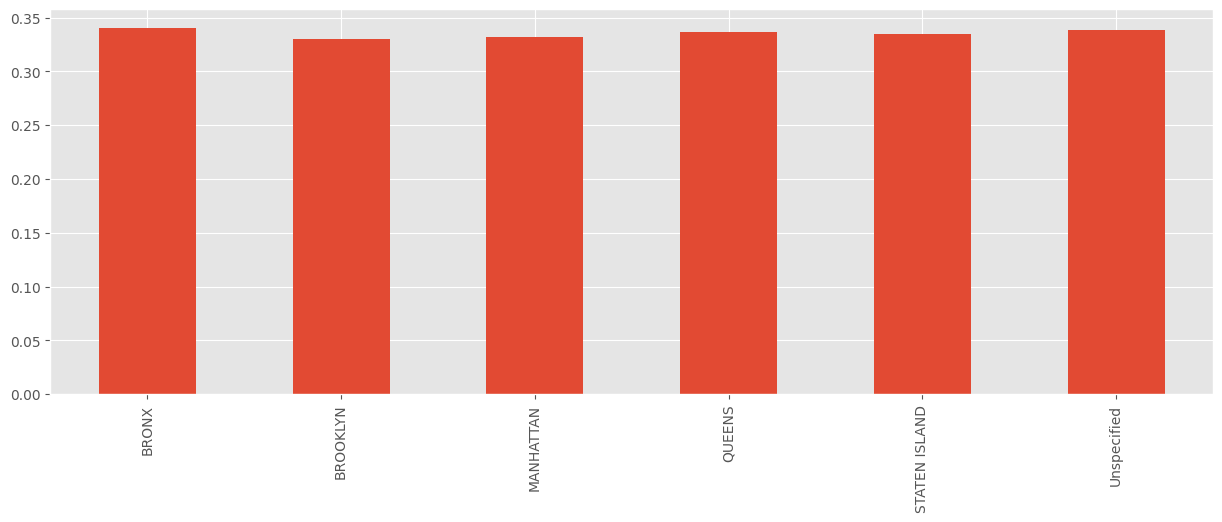

In [47]:
(noise_complaint_counts_pointer / complaint_counts_pointer.astype(float)).plot(kind='bar')

So Bronx really does complain more about noise than the other boroughs in our mock! Neat.

In [48]:
res_ptr = noise_complaint_counts_pointer / complaint_counts_pointer.astype(float)

## Request real result

Now that we finished our analysis on the pointers, we can request the real result.

In [49]:
res_ptr.request(guest_client)

```python
class Request:
  id: str = 51b91a53d08e4a678840d6dc8b1dd19b
  requesting_user_verify_key: str = 5501e7847350ff93d7ddbd64cedf6f9ecfc523c893f9d9460cd89f5e37c33ffe
  approving_user_verify_key: str = None
  request_time: str = 2023-05-17 13:18:38
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 8f59d4f942bb42ef8cfedd2bd3c90330
  request_hash: str = "7e53462fc930aea1793f544f98a01a2a06baa88eb0b6f16010ec6ae71ccd81f9"
  changes: str = [syft.service.request.request.ActionStoreChange]

```

# Data owner: approve request

In [50]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")
domain_client.api.services.request[0].approve()

<class 'syft.service.response.SyftSuccess'>: Request 51b91a53d08e4a678840d6dc8b1dd19b changes applied

# Data scientist: fetch result

In [51]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")


In [52]:
real_result = res_ptr.get_from(guest_client)

<AxesSubplot: >

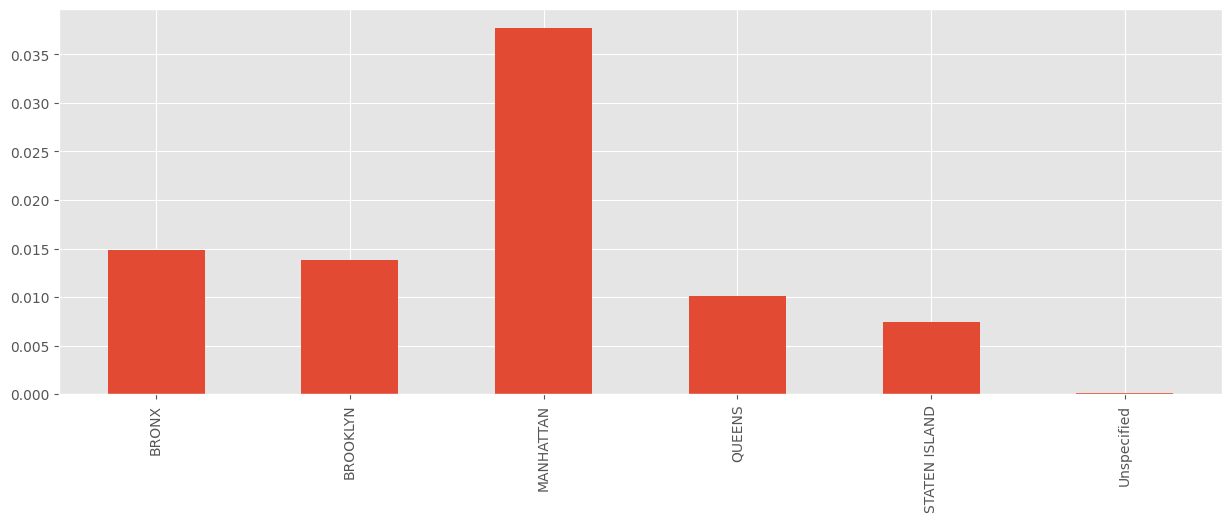

In [53]:
real_result[:10].plot(kind="bar")